In [1]:
using Roots
using SteadyStateDiffEq
using PyPlot
using Revise
using Parameters

include("ODE.jl")

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/claresinger/.julia/packages/PyPlot/4wzW1/src/init.jl:192


mlm (generic function with 1 method)

In [2]:
function run_steadystate(params)
   # steady state run
    params.dSST = 0.0;
    
    z0 = 0.0;
    qtM0 = params.RHsurf * q_sat(z0,params.SST0);
    hM0 = Cp * (params.SST0 - 2.0) + L0 * qtM0;
    
    zi0 = 900.0
    u0 = [zi0, hM0, qtM0, params.SST0];
    
    prob = SteadyStateProblem(mlm, u0, params);
    tspan = 3600.0 * 24.0 * 100.0;
    tol = 1e-6;
    
    sol = solve(prob, DynamicSS(Rosenbrock23(autodiff=false);abstol=tol,reltol=0.0,tspan=tspan));
    uf = sol.u;
    println(sol.retcode);

    return u0, uf, params
end

run_steadystate (generic function with 1 method)

In [3]:
@with_kw mutable struct CPQ_params
    SST0::Real = 290.0; # (K)
    dSST::Real = 0.0; # (K/day)
    
    D::Real = 6.0e-6; # (1/s)
    DFR::Real = 74.0; # (W/m^2)
    
    RHsurf::Real = 0.80;
    RHft::Real = 0.25;
    
    Gamma_q::Real = -3e-6; # (kg/kg/m)
    sft0::Real = 297; # (K)
    Gamma_s::Real = 5e-3; # (K/m)
    qft0::Real = calc_qft0(RHft, Gamma_q, sft0, Gamma_s); # (kg/kg)
    
    A::Real = 2.0;

    LHF::Real = 107.0; # (W/m^2)
    SHF::Real = 2.3; # (W/m^2)
    
    etype::ent_type = bflux();
    rtype::rad_type = direct();
    ftype::flux_type = fixFlux();
end

function calc_qft0(RHft, Gamma_q, sft0, Gamma_s)
    # calculate qft0
    zft = 900.0;
    qft(x) = x + Gamma_q * zft;
    hft(x) = Cp * (sft0 + Gamma_s * zft) + L0 * qft(x);
    Tft(x) = temp(zft, hft(x), qft(x));
    f(x) = x .- q_sat(zft, Tft(x)) .* RHft;
    qft0 = find_zero(f, (0.0,0.1), Bisection());
    qft0 = qft0 - Gamma_q * zft;
    return qft0
end

function set_run_params(vars, xs, etype::ent_type, rtype::rad_type, ftype::flux_type)
    p = CPQ_params();
    
    for (i,var) in enumerate(vars)
        x = xs[i];
        
        if var == "DFR"
            p.DFR = x
        elseif var == "D"
            p.D = x
        elseif var == "inv"
            p.sft0 = x
        elseif var == "SST"
            p.SST0 = x
        elseif var == "LHF"
            p.LHF = x
        elseif var == "SHF"
            p.SHF = x
        end                      
    end
                    
    p.etype = etype;
    p.rtype = rtype;
    p.ftype = ftype;
    
    return p
end
                    
function set_baseline_run_params(vars,xs,etype::ent_type,rtype::rad_type, ftype::flux_type)
    p = CPQ_params();
    vars = reverse(vars);
    xs = reverse(xs);
    
    for (i,var) in enumerate(vars)
        x = xs[i];
        
        if var == "DFR"
            p.DFR = x
        elseif var == "LHF"
            p.LHF = x
        elseif var == "SHF"
            p.SHF = x
        elseif var == "Bo"
            p.SHF = p.LHF * x                               
        elseif var == "D"
            p.D = x
        elseif var == "inv"
            p.sft0 = x
        elseif var == "SST"
            p.SST0 = x
        end                      
    end
                    
    p.etype = etype;
    p.rtype = rtype;
    p.ftype = ftype;
    
    return p
end

set_baseline_run_params (generic function with 1 method)

In [4]:
function run_base(etype::ent_type, rtype::rad_type, ftype::flux_type)
    par = set_run_params(["none"],[0.0],etype,rtype,ftype);
    println(par);
    u0, uf, par = run_steadystate(par);
    println("u0: ",u0)
    println("uf: ",uf)
    du = zeros(4);
    mlm(du, uf, par, 0.0)
    println("du/u: ", du ./ uf)
    zi,hM,qM,SST = uf;
    println("we = ",we(zi,hM,qM,SST,par,par.etype,par.rtype)*1000, " (mm/s)")
    println("zb = ",LCL(zi,hM,qM)," (m)")
    println("RH0 = ",RH(0.0,hM,qM)*100.0," (%)")
    println("LHF = ",calc_LHF(qM,SST,par)," (W/m2)")
    println("SHF = ",calc_SHF(hM,qM,SST,par)," (W/m2)")                                     
    println()
    return uf, par
end

run_base (generic function with 1 method)

In [5]:
include("ODE.jl")

ety = bflux();
rty = direct();
fty = fixFlux();
ubase, pbase = run_base(ety, rty, fty);

CPQ_params
  SST0: Float64 290.0
  dSST: Float64 0.0
  D: Float64 6.0e-6
  DFR: Float64 74.0
  RHsurf: Float64 0.8
  RHft: Float64 0.25
  Gamma_q: Float64 -3.0e-6
  sft0: Int64 297
  Gamma_s: Float64 0.005
  qft0: Float64 0.006708503509872937
  A: Float64 2.0
  LHF: Float64 107.0
  SHF: Float64 2.3
  etype: bflux bflux()
  rtype: direct direct()
  ftype: fixFlux fixFlux()

Success
u0: [900.0, 3.13275e5, 0.0096493, 290.0]
uf: [1007.21, 3.17323e5, 0.00958143, 290.0]
du/u: [-7.85208e-12, -9.21306e-13, -4.40594e-12, 0.0]
we = 6.043275596112881 (mm/s)
zb = 712.3456557285426 (m)
RH0 = 68.79952761429549 (%)
LHF = 107.0 (W/m2)
SHF = 2.299999999999997 (W/m2)



In [53]:
function run_exp(var, etype::ent_type, rtype::rad_type, ftype::flux_type)
    
    default = CPQ_params();
    
    num = 3;
    pert = 20/100; LHFs = default.LHF .* collect(range(1.0-pert, length=num, stop=1.0+pert));                                 
    pert = 24/100; DFRs = default.DFR .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 90/100; SHFs = default.SHF .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 6/100; Ds = default.D .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 0.5/100; sft0s = default.sft0 .* collect(range(1.0-pert, length=num, stop=1.0+pert));
        
    # create empty arrays for output
    u0s = Any[];
    ufs = Any[];
    params = Any[];

    if var == "DFR"
        x_list = DFRs
    elseif var == "D"
        x_list = Ds
    elseif var == "inv"
        x_list = sft0s
    elseif var == "SST"
        x_list = SSTs
    elseif var == "LHF"
        x_list = LHFs
    elseif var == "SHF"
        x_list = SHFs
    end
    
    for x in x_list
        # define parameter array
        par = set_run_params([var],[x],etype,rtype,ftype);  
                        
        # run MLM to steady state
        u0, uf, par = run_steadystate(par);

        # print output
        println("u0: ",u0)
        println("uf: ",uf)
        du = zeros(4);
        mlm(du, uf, par, 0.0)
        println("du/u: ", du ./ uf)
        zi,hM,qM,SST = uf;
        println("we = ",we(zi,hM,qM,SST,par,par.etype,par.rtype)*1000, " (mm/s)")
        println("eta = ",calc_eta(uf,par));
        println("zb = ",LCL(zi,hM,qM)," (m)")
        println("RH0 = ",RH(0.0,hM,qM)*100.0," (%)")
        println("LHF = ",calc_LHF(qM,SST,par)," (W/m2)")
        println("SHF = ",calc_SHF(hM,qM,SST,par)," (W/m2)")
        println()

        # add output to array
        push!(u0s, u0)
        push!(ufs, uf)
        push!(params, par)
    end
    
    return u0s, ufs, params
end
                    
function run_dense_exp(var, etype::ent_type, rtype::rad_type, ftype::flux_type)
    default = CPQ_params();
    
    num = 7;
    pert = 10/100; LHFs = default.LHF .* collect(range(1.0-pert, length=num, stop=1.0+pert));                                 
    pert = 12/100; DFRs = default.DFR .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 90/100; SHFs = default.SHF .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 12/100; Ds = default.D .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 0.5/100; sft0s = default.sft0 .* collect(range(1.0-pert, length=num, stop=1.0+pert));
        
    # create empty arrays for output
    u0s = Any[];
    ufs = Any[];
    params = Any[];

    if var == "DFR"
        x_list = DFRs
    elseif var == "D"
        x_list = Ds
    elseif var == "inv"
        x_list = sft0s
    elseif var == "SST"
        x_list = SSTs
    elseif var == "LHF"
        x_list = LHFs
    elseif var == "SHF"
        x_list = SHFs
    end
    
    for x in x_list
        # define parameter array
        par = set_run_params([var],[x],etype,rtype,ftype);  
                        
        # run MLM to steady state
        u0, uf, par = run_steadystate(par);

        # add output to array
        push!(u0s, u0)
        push!(ufs, uf)
        push!(params, par)
    end
    
    return u0s, ufs, params
end
                                        
function run_grid_exp(num, var1, var2, etype::ent_type, rtype::rad_type, ftype::flux_type, exp_type; bowen=-1.0)
    default = CPQ_params();
    
#     LHFs = default.LHF .* collect(range(1.0, length=num, stop=1.0+0.05));                         
#     DFRs = default.DFR .* collect(range(1.0, length=num, stop=1.0-0.06));
#     SHFs = default.SHF .* collect(range(1.0, length=num, stop=1.0-0.45));
#     Ds = default.D .* collect(range(1.0, length=num, stop=1.0-0.03));
#     sft0s = default.sft0 .* collect(range(1.0, length=num, stop=1.0-0.01));
                                            
    pert = 10/100; LHFs = default.LHF .* collect(range(1.0-pert, length=num, stop=1.0+pert));                                 
    pert = 12/100; DFRs = default.DFR .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 90/100; SHFs = default.SHF .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 12/100; Ds = default.D .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 0.5/100; sft0s = default.sft0 .* collect(range(1.0-pert, length=num, stop=1.0+pert));
        
    # create empty arrays for output
    u0s = Any[];
    ufs = Any[];
    params = Any[];

    if var1 == "DFR"
        x1_list = DFRs
    elseif var1 == "SHF"
        x1_list = SHFs
    elseif var1 == "D"
        x1_list = Ds
    elseif var1 == "inv"
        x1_list = sft0s
    end
    if var2 == "LHF"
        x2_list = LHFs
    end
    
    for x1 in x1_list
        println(var1,"\t",x1);
        for x2 in x2_list
            println(var2,"\t",x2);
                                                    
            vars = [var1,var2];
            xs = [x1,x2];
            
            # define parameter array
            if exp_type == "baseline"
                par = set_baseline_run_params(vars,xs,etype,rtype,ftype);
            elseif exp_type == "bowen"
                par = set_fixedBo_run_params(vars,xs,etype,rtype,ftype,bowen);
            elseif exp_type == "SCT"
                par = set_SCT_run_params(vars,xs,etype,rtype,ftype);
            elseif exp_type == "CC"
                par = set_CC_run_params(vars,xs,etype,rtype,ftype);
            end
#             println(par);

            # run MLM to steady state
            u0, uf, par = run_steadystate(par);
                                                        
            # print output
            if num < 3
                println("u0: ",u0)
                println("uf: ",uf)
                du = zeros(4);
                mlm(du, uf, par, 0.0)
                println("du/u: ", du ./ uf)
                zi,hM,qM,SST = uf;
                println("we = ",we(zi,hM,qM,SST,par,par.etype,par.rtype)*1000, " (mm/s)")
                println("zb = ",LCL(zi,hM,qM)," (m)")
                println("RH0 = ",RH(0.0,hM,qM)*100.0," (%)")
                println("LHF = ",calc_LHF(qM,SST,par)," (W/m2)")
                println("SHF = ",calc_SHF(hM,qM,SST,par)," (W/m2)")
                println()
            end

            # add output to array
            push!(u0s, u0)
            push!(ufs, uf)
            push!(params, par)
        end
    end
    
    return u0s, ufs, params
end

run_grid_exp (generic function with 1 method)

DFR	65.12
LHF	96.3
Success
LHF	101.64999999999999
Success
LHF	107.0
Success
LHF	112.35000000000001
Success
LHF	117.7
Success
DFR	69.56
LHF	96.3
Success
LHF	101.64999999999999
Success
LHF	107.0
Success
LHF	112.35000000000001
Success
LHF	117.7
Success
DFR	74.0
LHF	96.3
Success
LHF	101.64999999999999
Success
LHF	107.0
Success
LHF	112.35000000000001
Success
LHF	117.7
Success
DFR	78.44
LHF	96.3
Success
LHF	101.64999999999999
Success
LHF	107.0
Success
LHF	112.35000000000001
Success
LHF	117.7
Success
DFR	82.88000000000001
LHF	96.3
Success
LHF	101.64999999999999
Success
LHF	107.0
Success
LHF	112.35000000000001
Success
LHF	117.7
Success
D	5.28e-6
LHF	96.3
Success
LHF	101.64999999999999
Success
LHF	107.0
Success
LHF	112.35000000000001
Success
LHF	117.7
Success
D	5.64e-6
LHF	96.3
Success
LHF	101.64999999999999
Success
LHF	107.0
Success
LHF	112.35000000000001
Success
LHF	117.7
Success
D	6.0e-6
LHF	96.3
Success
LHF	101.64999999999999
Success
LHF	107.0
Success
LHF	112.35000000000001
Success
LHF	117.

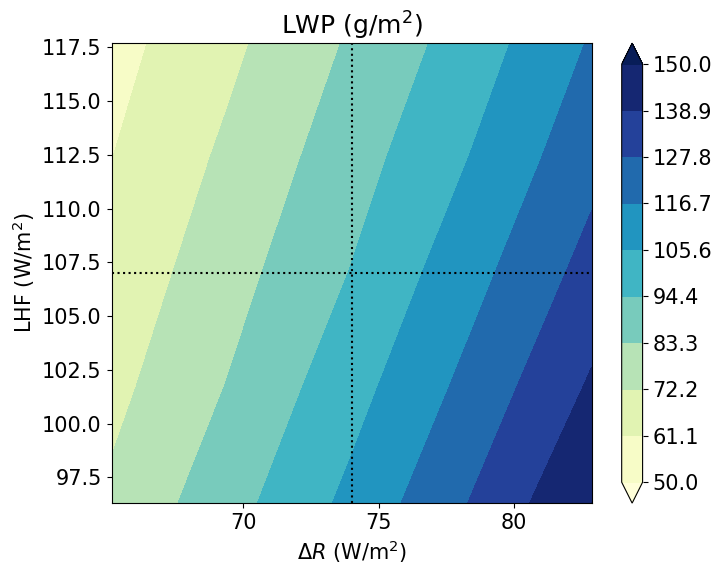

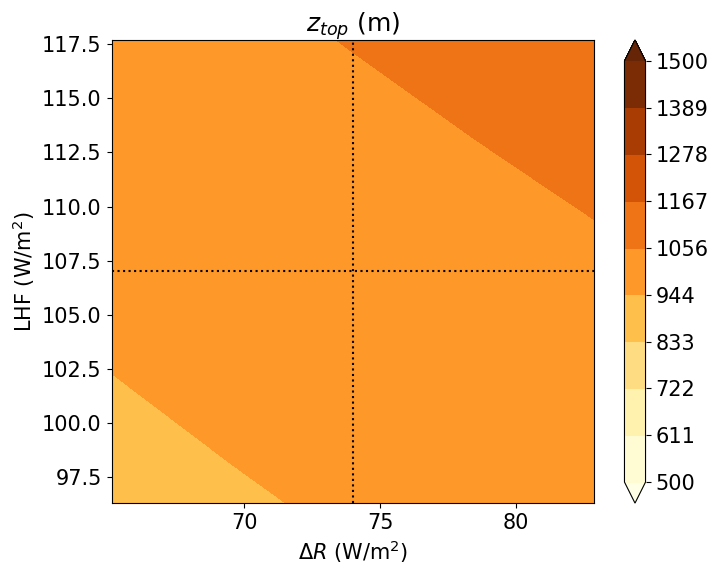

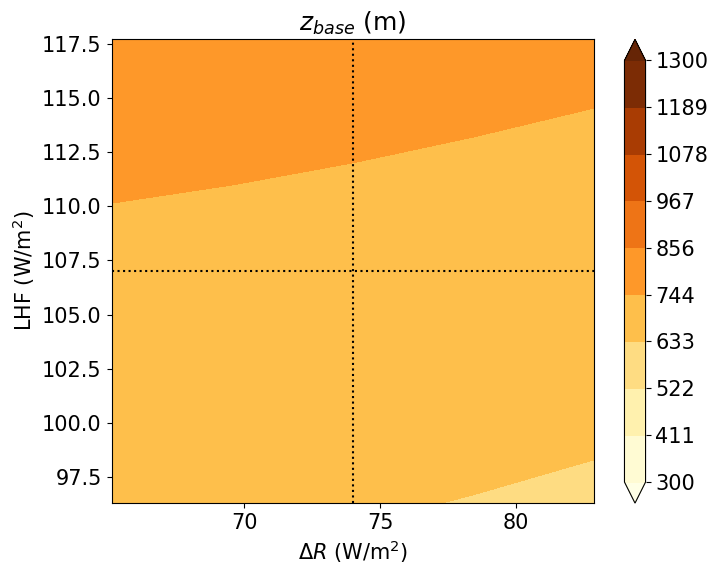

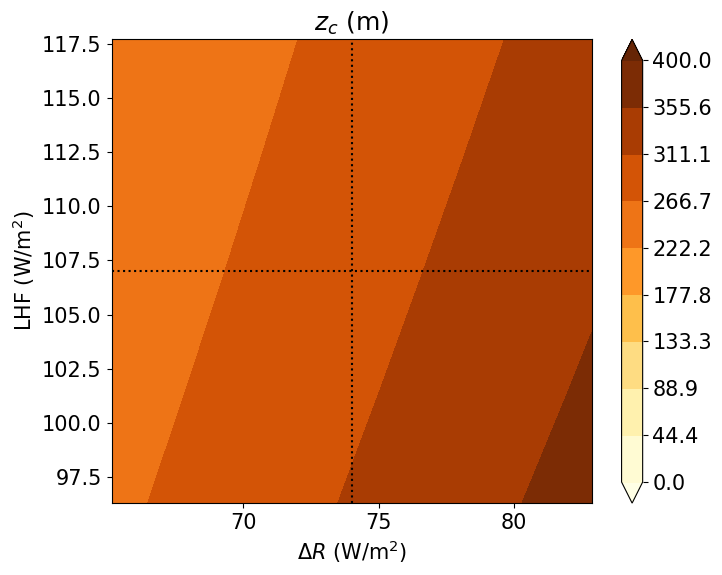

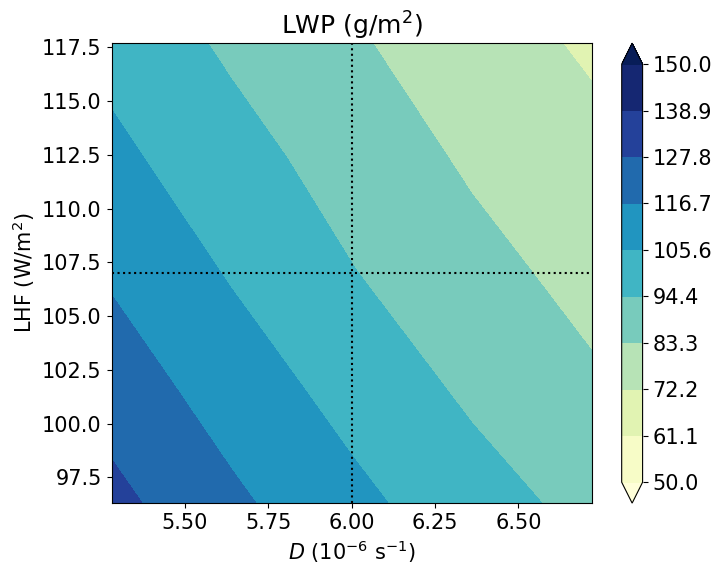

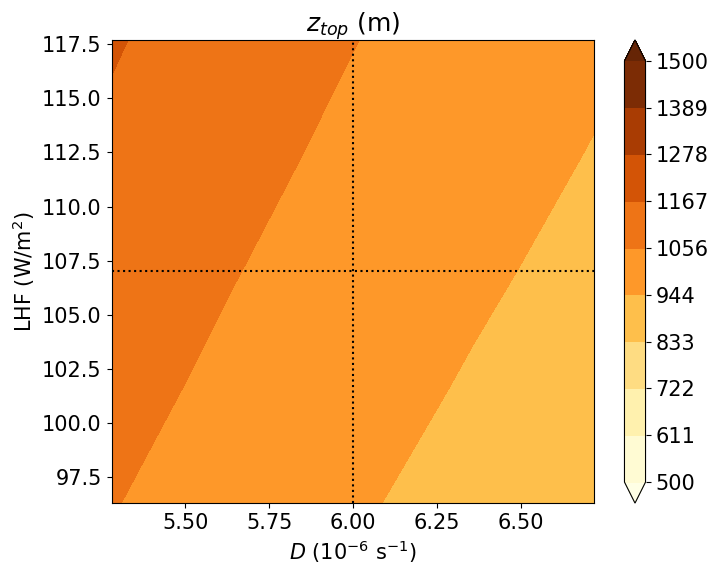

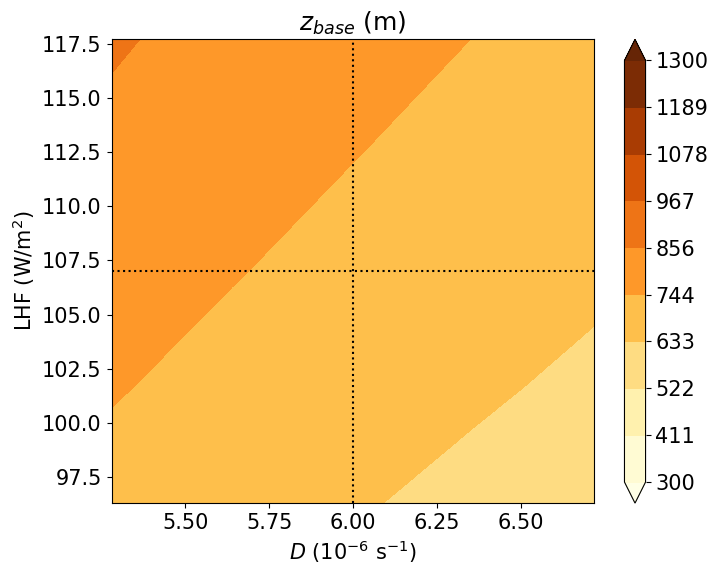

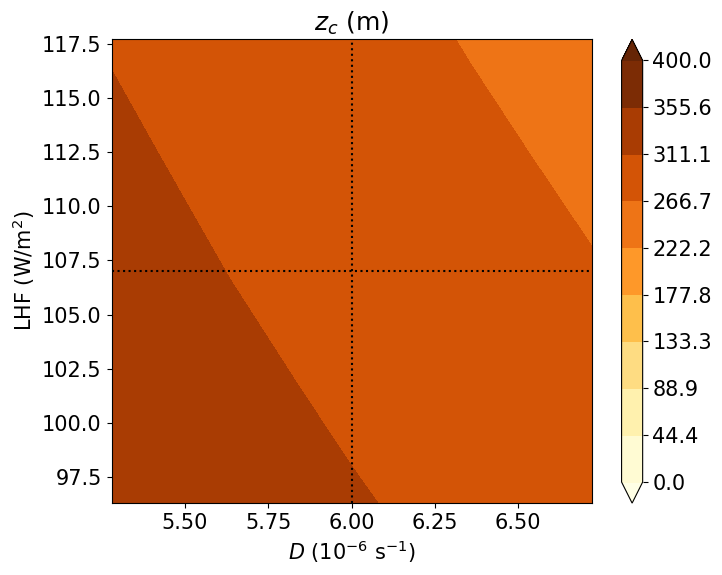

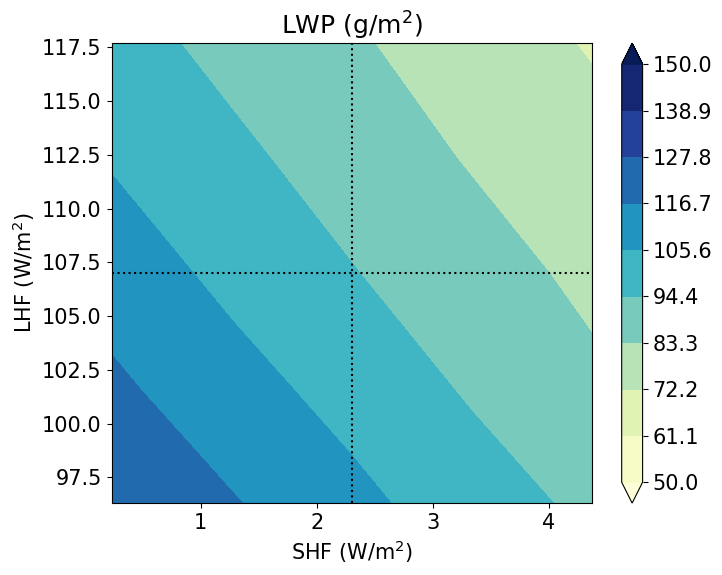

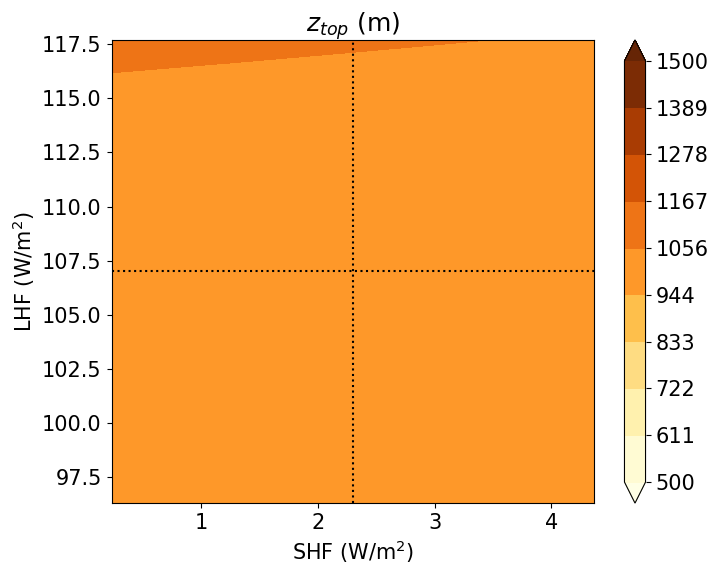

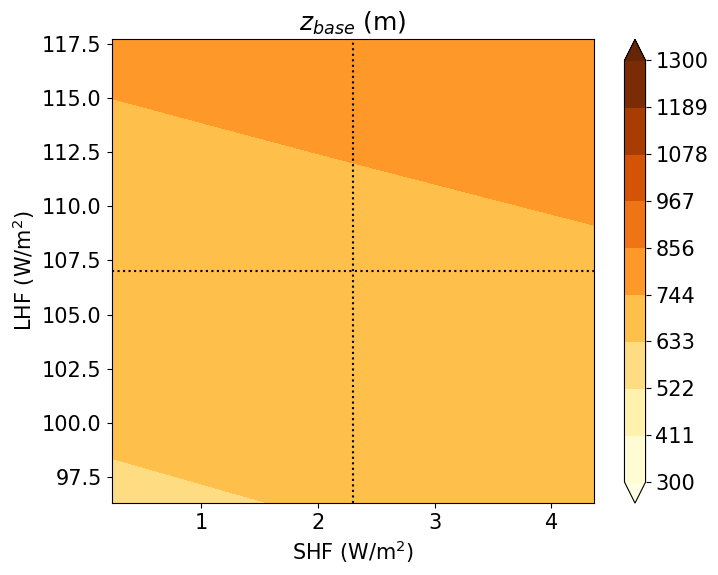

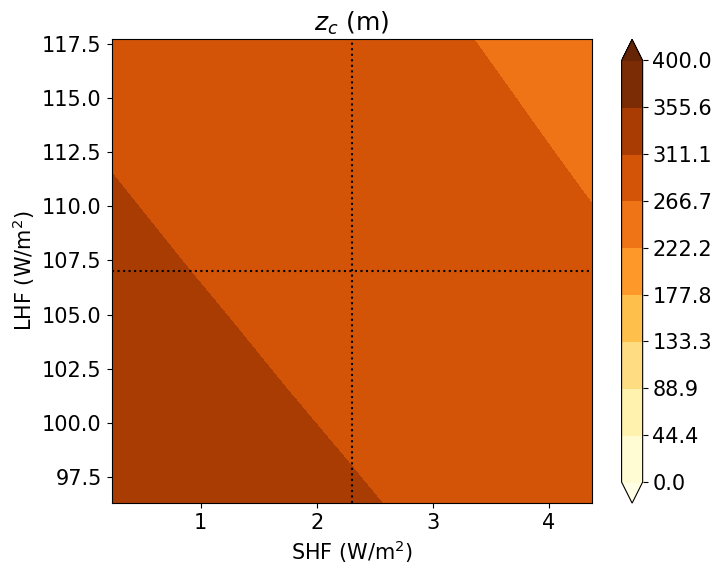

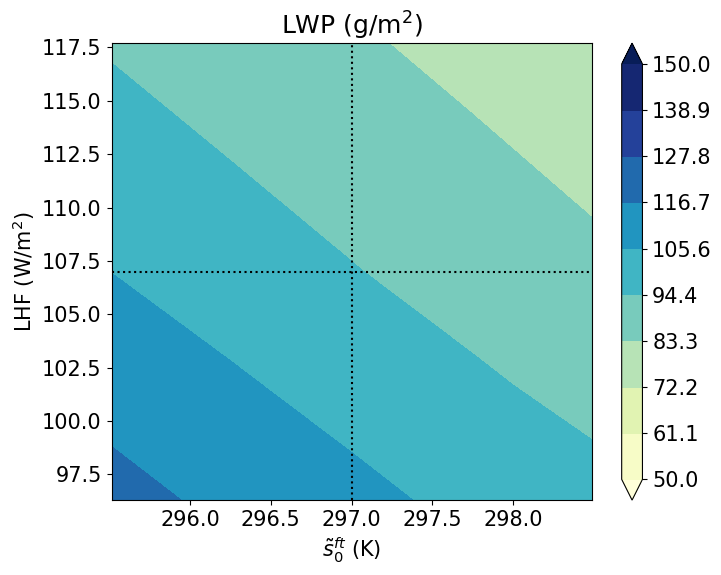

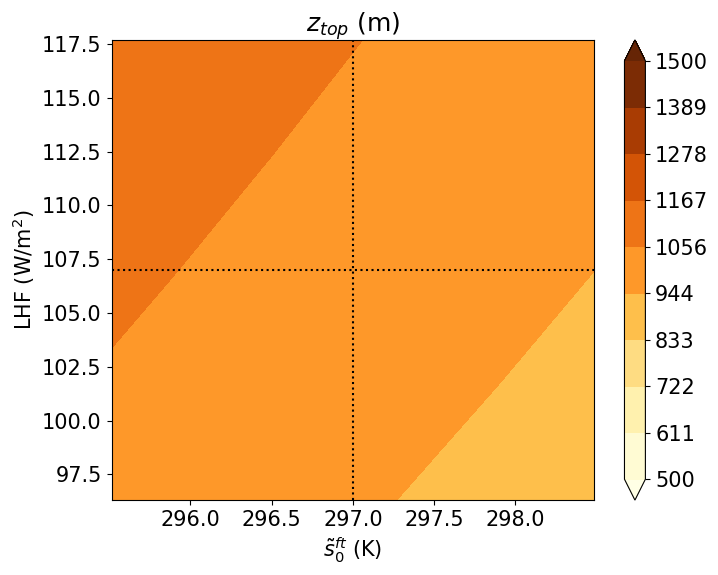

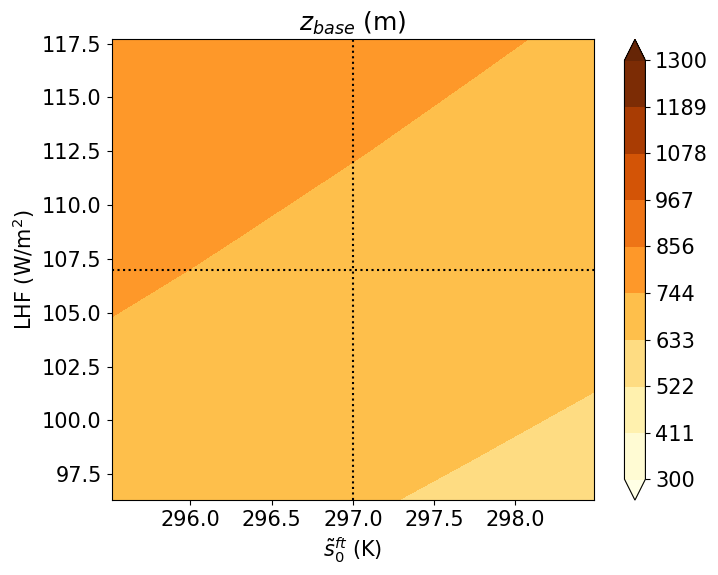

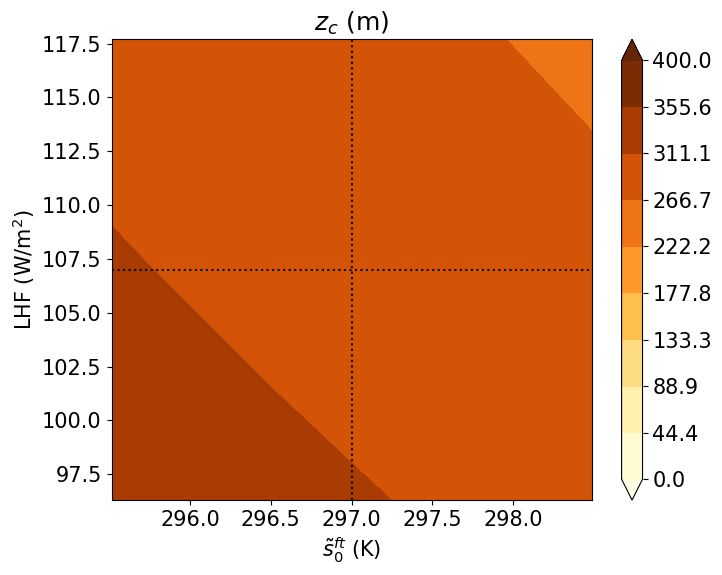

In [37]:
include("ODE.jl")
include("ContourPlots.jl")

ety = bflux();
rty = direct();
fty = fixFlux();

vars = ["DFR","D","SHF","inv"];
phis = ["LWP","zi","zb","zc"];

num = 5;
var2 = "LHF";
exp_type = "baseline";
bowen = 0.0;

for var1 in vars
    u0s, ufs, params = run_grid_exp(num, var1, var2, ety, rty, fty, exp_type; bowen=bowen);
    
    # if exp_type == "bowen"
    #     exp_type = string("bowen",bowen);
    # end
    
    for phi in phis
        plot_generic_contour(ufs, params, var1, var2, phi, exp_type)
    end
end

In [41]:
include("ODE.jl")
include("ProfilePlots.jl")

ety = bflux();
rty = direct();
fty = fixFlux();
var_list = ["DFR","D","LHF","SHF","inv"];
var_list = ["DFR"];

#phi_list = ["theta","T","p","h","qt","ql","RH","cf","bflux"];
#phi_list = ["ql","theta","T","RH","bflux"];
phi_list = ["ql","theta"];

for (i,var) in enumerate(var_list)
    println("\n\n",var);
    u0s, ufs, params = run_exp(var, ety, rty, fty);
#     plot_three_profs_generic(ufs, params, "h", "qt", "ql", var)
#     for phi in phi_list
#         print(phi,"\t");
#         plot_prof_generic(ufs, params, phi, var);
#     end
end



DFR
Success
u0: [900.0, 3.13275e5, 0.0096493, 290.0]
uf: [922.867, 320646.0, 0.0103732, 290.0]
du/u: [1.51334e-13, 1.29155e-12, 8.77639e-12, 0.0]
we = 5.537203830580006 (mm/s)
eta = 0.8325710814212246
zb = 731.9108707949082 (m)
RH0 = 68.30682848122109 (%)
LHF = 107.0 (W/m2)
SHF = 2.299999999999997 (W/m2)

Success
u0: [900.0, 3.13275e5, 0.0096493, 290.0]
uf: [1007.21, 3.17323e5, 0.00958143, 290.0]
du/u: [-7.85208e-12, -9.21306e-13, -4.40594e-12, 0.0]
we = 6.043275596112881 (mm/s)
eta = 0.8727478302272093
zb = 712.3456557285426 (m)
RH0 = 68.79952761429549 (%)
LHF = 107.0 (W/m2)
SHF = 2.299999999999997 (W/m2)

Success
u0: [900.0, 3.13275e5, 0.0096493, 290.0]
uf: [1077.79, 3.14544e5, 0.0089837, 290.0]
du/u: [-1.00907e-12, -6.6968e-13, -4.12615e-12, 0.0]
we = 6.466740874609341 (mm/s)
eta = 0.8973780868894
zb = 671.3566575910717 (m)
RH0 = 70.11775027982766 (%)
LHF = 107.0 (W/m2)
SHF = 2.299999999999997 (W/m2)



In [52]:
ubase, pbase = run_base(ety, rty, fty);

CPQ_params
  SST0: Float64 290.0
  dSST: Float64 0.0
  D: Float64 6.0e-6
  DFR: Float64 74.0
  RHsurf: Float64 0.8
  RHft: Float64 0.25
  Gamma_q: Float64 -3.0e-6
  sft0: Int64 297
  Gamma_s: Float64 0.005
  qft0: Float64 0.006708503509872937
  A: Float64 2.0
  LHF: Float64 107.0
  SHF: Float64 2.3
  etype: bflux bflux()
  rtype: direct direct()
  ftype: fixFlux fixFlux()

Success
u0: [900.0, 3.13275e5, 0.0096493, 290.0]
uf: [1007.21, 3.17323e5, 0.00958143, 290.0]
du/u: [-7.85208e-12, -9.21306e-13, -4.40594e-12, 0.0]
we = 6.043275596112881 (mm/s)
zb = 712.3456557285426 (m)
RH0 = 68.79952761429549 (%)
LHF = 107.0 (W/m2)
SHF = 2.299999999999997 (W/m2)



In [77]:
zi0, hM0, qtM0, SST0 = ubase;
lwp0 = calc_LWP(zi0,hM0,qtM0) * 1000.0;
println(lwp0);

94.91052182394169


In [74]:
var = "SHF";
u0s, ufs, params = run_dense_exp(var, ety, rty, fty);

Success
Success
Success
Success
Success
Success
Success


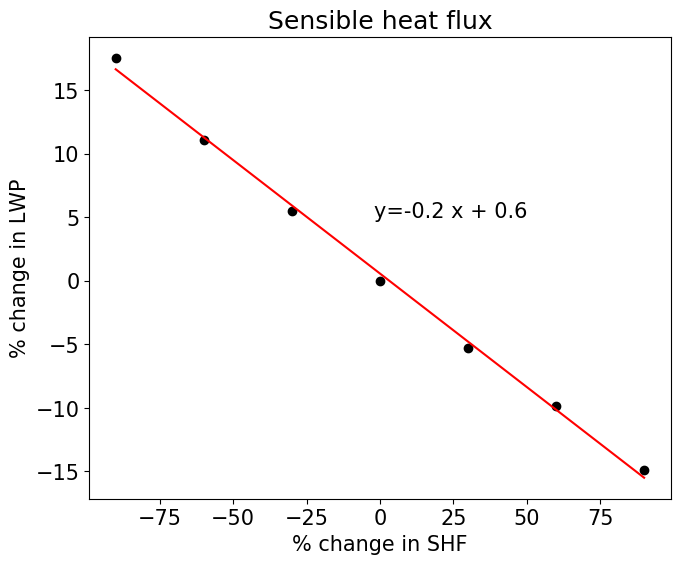

slope = -0.17851119298242876


In [75]:
include("LinAnalysis.jl")
plot_lwp(ubase, pbase, ufs, params, var);

In [56]:
include("ProfilePlots.jl")
include("StabilityPlots.jl")

#ety = bflux();
ety = minModel();

rty = direct();

# fty = varFlux();
# var_list = ["DFR","D","inv","SST"];

fty = fixFlux();
var_list = ["DFR","D","inv","LHF"];

ubase, pbase = run_base(ety, rty, fty);

ufs_list = Array{Any}(undef,length(var_list));
params_list = Array{Any}(undef,length(var_list));

for (i,var) in enumerate(var_list)
    println("\n\n",var);
    u0s, ufs, params = run_dense_exp(var, ety, rty, fty);
    plot_S(ubase, pbase, ufs, params, var);
    plot_S2(ubase, pbase, ufs, params, var);
    plot_Z(ubase, pbase, ufs, params, var);
    plot_S3(ubase, pbase, ufs, params, var);
    ufs_list[i] = ufs;
    params_list[i] = params;
end

println(ufs_list)

Success
u0: [900.0, 3.16511e5, 0.00993979, 292.5]
uf: [954.157, 3.15319e5, 0.00927974, 292.5]
du/u: [-4.86636e-12, 1.96092e-13, 1.7791e-12, 0.0]
we = 3.578083833507545 (mm/s)
zb = 615.5714683642823 (m)
RH0 = 72.2615447348606 (%)
LHF = 60.0 (W/m2)
SHF = 6.0 (W/m2)



DFR
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success


D
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success


inv
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
291.4573006855271	283.26527890630166
289.6534531601205	282.19324588508607
290.0568143515306	282.43649208729977
290.45872913279544	282.6768266091425
290.8592149772574	282.91430896909856
291.2582903316016	283.14898682006367
291.65597439025044	283.3809108456159
292.05228785736386	283.61012241855417
292.447245855902	283.8366673096775
292.8408852382712	284.06061941893546
293.23321303754847	284.2820033644284
291.4573006855271	283.26527890630166
289.6534531601205	282.19324588508607

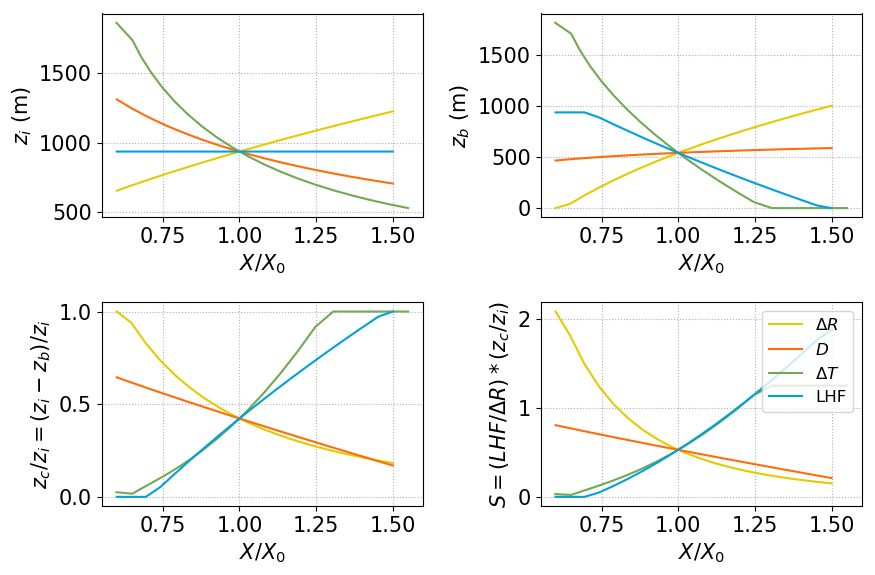

["DFR", "D", "inv", "LHF"]


In [42]:
include("StabilityPlots.jl")
println(var_list)
plot_S_multvar(ubase, pbase, ufs_list, params_list, var_list)
plot_S2_multvar(ubase, pbase, ufs_list, params_list, var_list)